In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.linear_model import LogisticRegression

import os 
import yaml


In [134]:
ENC_DATA_PATH = "../data/processed/2020/onehotencoded_df.pkl"
DATA_PATH = "../data/processed/2020/survey_results_public_processed.pkl"
EXPORT_FEATURES_DIR = "../data/processed/feature_engineering/"

In [20]:
enc_raw_df = pd.read_pickle(ENC_DATA_PATH)
raw_df = pd.read_pickle(DATA_PATH)
raw_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,"[ASP.NET, ASP.NET Core]",Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,[],Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,[],Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,[],Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,[Ruby on Rails],Just as welcome now as I felt last year,NaN,15,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,64858,NaN,Yes,NaN,16,NaN,NaN,NaN,United States,NaN,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,[],NaN,NaN,10,0
64457,64867,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Morocco,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
64458,64898,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Viet Nam,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
64459,64925,NaN,Yes,NaN,NaN,NaN,NaN,NaN,Poland,NaN,...,NaN,NaN,NaN,NaN,Angular;Angular.js;React.js,[],NaN,NaN,NaN,NaN


In [21]:
data = raw_df.copy() 
enc_data = enc_raw_df.copy()

# Student & Retired

In [27]:
# check if students in the dataset have a job
# Students that do not have a job will be deleted 
# from the dataset as their asnwers are not 
# relevent to our business case 

student_df = data[data['Employment'] == "Student"]
np.unique(student_df['DevType'].values)

# We noticed that all students that answered the survey 
# do not have a job. Therefore, we need to delete them from 
# the dataset as their answers does not relevent to our business case

array([list([])], dtype=object)

In [31]:
retired_df = data[data['Employment'] == "Retired"]
np.unique(retired_df['DevType'].values)

array([list([])], dtype=object)

In [33]:
enc_raw_df['DevType'].isna().sum()

Academic researcher                              0
Data or business analyst                         0
Data scientist or machine learning specialist    0
Database administrator                           0
Designer                                         0
DevOps specialist                                0
Developer, QA or test                            0
Developer, back-end                              0
Developer, desktop or enterprise applications    0
Developer, embedded applications or devices      0
Developer, front-end                             0
Developer, full-stack                            0
Developer, game or graphics                      0
Developer, mobile                                0
Educator                                         0
Engineer, data                                   0
Engineer, site reliability                       0
Engineering manager                              0
Marketing or sales professional                  0
Product manager                

In [36]:
# How the students and retired (They haven't any job) 
# encoded by the MultiLabelBinarizer

student_df.sample().iloc[0]

Respondent                                              28984
MainBranch             I am a student who is learning to code
Hobbyist                                                  Yes
Age                                                      23.0
Age1stCode                                                 19
                                       ...                   
WebframeWorkedWith                                         []
WelcomeChange         Just as welcome now as I felt last year
WorkWeekHrs                                               NaN
YearsCode                                                   4
YearsCodePro                                              NaN
Name: 28876, Length: 61, dtype: object

In [40]:
enc_raw_df.iloc[28876]['DevType'].sum()

np.int64(0)

In [41]:
retired_df.sample().iloc[0]

Respondent                                                        25859
MainBranch            I used to be a developer by profession, but no...
Hobbyist                                                            Yes
Age                                                                69.0
Age1stCode                                                           18
                                            ...                        
WebframeWorkedWith                                                   []
WelcomeChange         Not applicable - I did not use Stack Overflow ...
WorkWeekHrs                                                         NaN
YearsCode                                                            15
YearsCodePro                                                        NaN
Name: 25764, Length: 61, dtype: object

In [42]:
enc_raw_df.iloc[25764]['DevType'].sum()

np.int64(0)

In [43]:
# as the output of the previous cell. Students and retired are not associated to any job 
# their skills will not affect the choice of model

# Clustering

## Reduce Dimentionality

In [191]:
skills = enc_raw_df.drop('DevType', axis=1)
std_skills = StandardScaler().fit_transform(skills)
std_skills

array([[-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393],
       [-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393],
       [-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393],
       ...,
       [-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393],
       [-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393],
       [-0.24152408, -0.64600087, -0.49015788, ..., -0.27109262,
        -0.14436385, -0.19481393]])

In [192]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills.columns)

C:\Users\wannatry\Documents\Mellouky\Projects\jobme\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [193]:
tsne_projection

0          1
LanguageWorkedWith Assembly                2.223871  17.006033
                   Bash/Shell/PowerShell  10.101779   9.713655
                   C                       0.707907  16.925507
                   C#                    -35.221401   6.550000
                   C++                    -0.097229  16.866182
...                                             ...        ...
MiscTechWorkedWith Teraform               22.249218   2.006314
                   Torch/PyTorch          16.760941  29.615484
                   Unity 3D              -24.607645  14.733852
                   Unreal Engine         -23.989326  15.145640
                   Xamarin               -36.901226   9.232488

[90 rows x 2 columns]

In [194]:
tnse_projection = pd.DataFrame(tsne_projection, index=skills.T.index)

In [195]:
fig = px.scatter(x=tnse_projection[0], y=tnse_projection[1], text=tnse_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

## Create Clusters

In [196]:

range_n_cluster = list(range(10,25))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

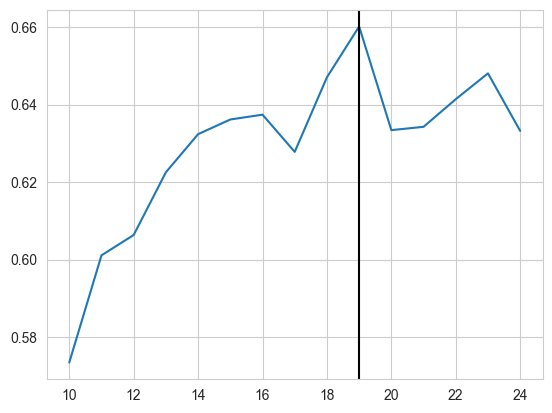

In [197]:
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [198]:
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]

cluster_labels

['skills_group_3',
 'skills_group_14',
 'skills_group_3',
 'skills_group_0',
 'skills_group_3',
 'skills_group_17',
 'skills_group_5',
 'skills_group_9',
 'skills_group_15',
 'skills_group_8',
 'skills_group_9',
 'skills_group_15',
 'skills_group_10',
 'skills_group_16',
 'skills_group_6',
 'skills_group_14',
 'skills_group_1',
 'skills_group_1',
 'skills_group_13',
 'skills_group_15',
 'skills_group_9',
 'skills_group_2',
 'skills_group_16',
 'skills_group_12',
 'skills_group_0',
 'skills_group_2',
 'skills_group_2',
 'skills_group_18',
 'skills_group_5',
 'skills_group_10',
 'skills_group_8',
 'skills_group_6',
 'skills_group_0',
 'skills_group_4',
 'skills_group_6',
 'skills_group_8',
 'skills_group_5',
 'skills_group_5',
 'skills_group_10',
 'skills_group_18',
 'skills_group_10',
 'skills_group_3',
 'skills_group_5',
 'skills_group_10',
 'skills_group_4',
 'skills_group_8',
 'skills_group_5',
 'skills_group_14',
 'skills_group_16',
 'skills_group_0',
 'skills_group_3',
 'skills_gro

In [199]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=600, width=1000, title_text='Cluster')
fig.show()

In [200]:
skills_clusters = pd.Series(tsne_projection.index.droplevel(0)).groupby(cluster_labels).unique()
skills_clusters

skills_group_0     [C#, VBA, Microsoft SQL Server, Microsoft Azure, Windows, ASP.NET, ASP.NET Core, .NET, .NET Core, Xamarin]
skills_group_1                                           [Python, R, Django, Flask, Keras, Pandas, TensorFlow, Torch/PyTorch]
skills_group_10                                                    [Kotlin, Firebase, SQLite, Android, Google Cloud Platform]
skills_group_11                                                                                     [Unity 3D, Unreal Engine]
skills_group_12                                                                    [TypeScript, Angular, Angular.js, Cordova]
skills_group_13                                                                                         [Ruby, Ruby on Rails]
skills_group_14                                                                          [Bash/Shell/PowerShell, Perl, Linux]
skills_group_15                                                                                        [Haskell, Julia

In [201]:
for cluster, skills_ in skills_clusters.items():
    print("Cluster name:", cluster)
    print("Skills set: ", skills_)
    print(f"-----------------------------")

Cluster name: skills_group_0
Skills set:  ['C#' 'VBA' 'Microsoft SQL Server' 'Microsoft Azure' 'Windows' 'ASP.NET'
 'ASP.NET Core' '.NET' '.NET Core' 'Xamarin']
-----------------------------
Cluster name: skills_group_1
Skills set:  ['Python' 'R' 'Django' 'Flask' 'Keras' 'Pandas' 'TensorFlow'
 'Torch/PyTorch']
-----------------------------
Cluster name: skills_group_10
Skills set:  ['Kotlin' 'Firebase' 'SQLite' 'Android' 'Google Cloud Platform']
-----------------------------
Cluster name: skills_group_11
Skills set:  ['Unity 3D' 'Unreal Engine']
-----------------------------
Cluster name: skills_group_12
Skills set:  ['TypeScript' 'Angular' 'Angular.js' 'Cordova']
-----------------------------
Cluster name: skills_group_13
Skills set:  ['Ruby' 'Ruby on Rails']
-----------------------------
Cluster name: skills_group_14
Skills set:  ['Bash/Shell/PowerShell' 'Perl' 'Linux']
-----------------------------
Cluster name: skills_group_15
Skills set:  ['Haskell' 'Julia' 'Rust']
---------------

In [217]:
tmp = skills.droplevel(0, axis=1)[['C#', 'VBA', 'Microsoft SQL Server', 'Microsoft Azure', 'Windows', 'ASP.NET',
 'ASP.NET Core', '.NET', '.NET Core', 'Xamarin']].sum(axis=1)
tmp.name = "cluster_name"
tmp

0        7
1        0
2        0
3        0
4        1
        ..
64456    0
64457    3
64458    0
64459    1
64460    6
Name: cluster_name, Length: 64461, dtype: int64

In [218]:
# calculate the sum of skills under each cluster a subject has

new_features = []

for cluster, skills_ in skills_clusters.items():
    cluster_sum = skills.droplevel(0, axis=1)[skills_].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)

In [219]:
fe_clustered_skills


,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,skills_group_18,skills_group_2,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,2,1,0,1,0,1,0,0,0,3,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64457,3,2,3,0,1,1,2,3,2,1,1,3,3,1,4,3,0,3,3
64458,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64459,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


# Illustration Model 

In [222]:
# We combine clusters with original features to check 
# the baseline model performances using both approaches 

combined_features_df = pd.concat([fe_clustered_skills, 
                                  skills.droplevel(0,axis=1)], 
                                 axis=1)
combined_features_df

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,Node.js,Pandas,Puppet,React Native,TensorFlow,Teraform,Torch/PyTorch,Unity 3D,Unreal Engine,Xamarin
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,2,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64457,3,2,3,0,1,1,2,3,2,1,...,0,0,0,0,0,0,0,0,0,0
64458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64459,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [221]:
roles_df = enc_raw_df['DevType'].copy()
roles_df

,Academic researcher,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices",...,"Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Scientist,Senior executive/VP,System administrator
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
64457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:

X_train, X_test, Y_train, Y_test = train_test_split(combined_features_df, roles_df, test_size=0.3, random_state=0)


## Compute samples weight to deal with classes imbalance


In [228]:
roles_df

,Academic researcher,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices",...,"Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Scientist,Senior executive/VP,System administrator
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
64457,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64458,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
class_weights = 1 / roles_df.sum(axis=0)
class_weights


Academic researcher                              0.000282
Data or business analyst                         0.000249
Data scientist or machine learning specialist    0.000251
Database administrator                           0.000175
Designer                                         0.000188
DevOps specialist                                0.000168
Developer, QA or test                            0.000253
Developer, back-end                              0.000037
Developer, desktop or enterprise applications    0.000085
Developer, embedded applications or devices      0.000211
Developer, front-end                             0.000055
Developer, full-stack                            0.000037
Developer, game or graphics                      0.000359
Developer, mobile                                0.000105
Educator                                         0.000342
Engineer, data                                   0.000268
Engineer, site reliability                       0.000515
Engineering ma

In [243]:
np.multiply(class_weights.values, Y_train.values)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00028153, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00024851, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [127]:
# Assign class weight as an inverse of its frequency 
class_weights = (1 / roles_df.sum(axis=0))

# Multiply class weights with the 1 hot encoded values and get the mean of each sample
sample_weight = np.multiply(class_weights.values, Y_train.values).sum(axis=1)

In [128]:
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / 
            (confusion_matrix[1,1] + 
             (0.5 * (confusion_matrix[0,1] + confusion_matrix[1,0]))
            ))

In [129]:
feature_sets = {'original': skills.droplevel(0,axis=1).columns.tolist(), 
                'clusters': fe_clustered_skills.columns.tolist()}

In [244]:
for feature_set_name, feature_set in feature_sets.items():
    print(feature_set)
    break 

['Assembly', 'Bash/Shell/PowerShell', 'C', 'C#', 'C++', 'Dart', 'Go', 'HTML/CSS', 'Haskell', 'Java', 'JavaScript', 'Julia', 'Kotlin', 'Objective-C', 'PHP', 'Perl', 'Python', 'R', 'Ruby', 'Rust', 'SQL', 'Scala', 'Swift', 'TypeScript', 'VBA', 'Cassandra', 'Couchbase', 'DynamoDB', 'Elasticsearch', 'Firebase', 'IBM DB2', 'MariaDB', 'Microsoft SQL Server', 'MongoDB', 'MySQL', 'Oracle', 'PostgreSQL', 'Redis', 'SQLite', 'AWS', 'Android', 'Arduino', 'Docker', 'Google Cloud Platform', 'Heroku', 'IBM Cloud or Watson', 'Kubernetes', 'Linux', 'MacOS', 'Microsoft Azure', 'Raspberry Pi', 'Slack Apps and Integrations', 'Windows', 'WordPress', 'iOS', 'ASP.NET', 'ASP.NET Core', 'Angular', 'Angular.js', 'Django', 'Drupal', 'Express', 'Flask', 'Gatsby', 'Laravel', 'React.js', 'Ruby on Rails', 'Spring', 'Symfony', 'Vue.js', 'jQuery', '.NET', '.NET Core', 'Ansible', 'Apache Spark', 'Chef', 'Cordova', 'Flutter', 'Hadoop', 'Keras', 'Node.js', 'Pandas', 'Puppet', 'React Native', 'TensorFlow', 'Teraform', 'Tor

In [245]:



results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, Y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.1522726823028018
.. Mean test F1: 0.15302623778847707

Feature set: clusters
.. Mean train F1: 0.19482931514478616
.. Mean test F1: 0.1935764024447557



# Export new features

In [246]:
features_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path)

In [140]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)